## Airline Sentiment Analysis

In [1]:
!pip install emoji

In [2]:
import numpy as np
import pandas as pd

import re
import emoji

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import f1_score, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Import stopwords with nltk.
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


- Read the training using pandas module and select only the sentiment and text columns
- Observe randomly generated 10 tweets for each sentiment

In [3]:
tweets = pd.read_csv('/content/drive/MyDrive/edureka/AI/Tweets-train/Tweets-train.csv', usecols=['airline_sentiment','text'])
#tweets = pd.read_csv('Tweets-train.csv', usecols=['airline_sentiment','text'])
tweets.sample(10)

,airline_sentiment,text
5721,neutral,@JetBlue Airways Stock Rating Lowered by Vetr ...
99,negative,@VirginAmerica @FiDiFamilies us too! Terrible ...
4773,neutral,@SouthwestAir needs to offer a college student...
3696,positive,@SouthwestAir I love you Southwest. I accept a...
3288,neutral,@SouthwestAir is the vinyl part of the prize too?
565,positive,"@united flight ua3576, gate b1. And tell ray I..."
4232,negative,@SouthwestAir Oops...no functioning bathrooms ...
5270,negative,@JetBlue 👍. I think I'll come take a nap at th...
505,negative,@united to speak to a real person to get this ...
9619,positive,@AmericanAir thanks! a response is better than...


In [4]:
tweets.isnull().sum()

,0
airline_sentiment,0
text,0


Prepare a function to clean all the above observed tokens from the tweet text.
Save changes in a new column
- Text contains references with ‘@’
- Text contains links (http , https )
- Text contains punctuations
- Text contains Emoticons

In [5]:
#ps=PorterStemmer()
def clean(tweet):
    new_tweets=tweet.lower()
    new_tweets=re.sub(r'@\w+','',new_tweets)
    new_tweets=re.sub(r'#','',new_tweets)
    new_tweets=re.sub(r':',' ',emoji.demojize(new_tweets))
    new_tweets=re.sub(r'http\S+','',new_tweets)
    new_tweets=re.sub(r'\$\S+','dollar',new_tweets)
    new_tweets=re.sub(r'[^a-z0-9\s]','',new_tweets)
    new_tweets=re.sub(r'[0-9]+','number',new_tweets)
    new_tweets=new_tweets.split(" ")
    #new_tweets=list(map(lambda x :ps.stem(x),new_tweets))
    #new_tweets=list(map(lambda x :x.strip(),new_tweets))
    #new_tweets= ",".join(str(item) for item in new_tweets)
    if '' in new_tweets:
        new_tweets.remove('')
    return new_tweets

tweets['clean_text'] = tweets.text.apply(clean)
tweets[['text', 'clean_text']].head()

,text,clean_text
0,@VirginAmerica plus you've added commercials t...,"[plus, youve, added, commercials, to, the, exp..."
1,@VirginAmerica I didn't today... Must mean I n...,"[i, didnt, today, must, mean, i, need, to, tak..."
2,@VirginAmerica it's really aggressive to blast...,"[its, really, aggressive, to, blast, obnoxious..."
3,@VirginAmerica and it's a really big bad thing...,"[and, its, a, really, big, bad, thing, about, it]"
4,"@VirginAmerica yes, nearly every time I fly VX...","[yes, nearly, every, time, i, fly, vx, this, e..."


In [6]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10640 entries, 0 to 10639
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  10640 non-null  object
 1   text               10640 non-null  object
 2   clean_text         10640 non-null  object
dtypes: object(3)
memory usage: 249.5+ KB


In [7]:
tweets[['text', 'clean_text','airline_sentiment']].head()

,text,clean_text,airline_sentiment
0,@VirginAmerica plus you've added commercials t...,"[plus, youve, added, commercials, to, the, exp...",positive
1,@VirginAmerica I didn't today... Must mean I n...,"[i, didnt, today, must, mean, i, need, to, tak...",neutral
2,@VirginAmerica it's really aggressive to blast...,"[its, really, aggressive, to, blast, obnoxious...",negative
3,@VirginAmerica and it's a really big bad thing...,"[and, its, a, really, big, bad, thing, about, it]",negative
4,"@VirginAmerica yes, nearly every time I fly VX...","[yes, nearly, every, time, i, fly, vx, this, e...",positive


In [8]:
group = tweets.groupby('airline_sentiment')['clean_text'].count()

In [9]:
group

,clean_text
airline_sentiment,
negative,6670
neutral,2248
positive,1722


List down the most common 15 words for each sentiment. Observe the results

In [10]:
from collections import Counter
count_words = Counter(tweets['clean_text'][0])

In [11]:
type(count_words)

collections.Counter

In [12]:
count_words

Counter({'plus': 1,
         'youve': 1,
         'added': 1,
         'commercials': 1,
         'to': 1,
         'the': 1,
         'experience': 1,
         'tacky': 1})

In [13]:
def count_words1(col1,col2):
  positive_words = []
  negative_words = []
  neutral_words = []
  for senti, text in tweets[[col1,col2]].values:
    if senti == 'positive':
      positive_words.extend(text)
    elif senti == 'negative':
      negative_words.extend(text)
    else:
      neutral_words.extend(text)
  #positive_word_counts = Counter(positive_words)
  #negative_word_counts = Counter(negative_words)
  #neutral_word_counts = Counter(neutral_words)
  positive_word_counts_15 = Counter(positive_words).most_common(15)
  negative_word_counts_15 = Counter(negative_words).most_common(15)
  neutral_word_counts_15 = Counter(neutral_words).most_common(15)
  return positive_word_counts_15, negative_word_counts_15, neutral_word_counts_15

In [14]:
pos, neg, neu = count_words1('airline_sentiment','clean_text')
print("\nPositive Word Counts:")
print(pos) # Print top 15 positive words
print("\nNegative Word Counts:")
print(neg) # Print top 15 negative words
print("\nNeutral Word Counts:")
print(neu) # Print top 15 negative words


Positive Word Counts:
[('', 1337), ('the', 689), ('to', 675), ('you', 631), ('for', 492), ('i', 447), ('thanks', 446), ('a', 372), ('thank', 335), ('and', 304), ('my', 262), ('flight', 262), ('number', 260), ('in', 235), ('on', 233)]

Negative Word Counts:
[('to', 4318), ('', 3147), ('number', 3116), ('the', 3013), ('i', 2604), ('a', 2300), ('flight', 2069), ('and', 2038), ('on', 2005), ('for', 1995), ('you', 1806), ('my', 1716), ('is', 1524), ('in', 1254), ('of', 1137)]

Neutral Word Counts:
[('', 1355), ('to', 1184), ('i', 842), ('the', 728), ('number', 635), ('a', 588), ('you', 530), ('on', 471), ('for', 442), ('flight', 422), ('my', 386), ('is', 371), ('in', 345), ('http', 340), ('and', 328)]


Remove Stopwords from all the tweets.
Save changes in a new column and list down most common 15 words.

In [15]:
# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
tweets['tweet_without_stopwords'] = tweets['clean_text'].apply(lambda x: [item for item in x if item not in stop])

In [16]:
tweets['tweet_without_stopwords'].head()

,tweet_without_stopwords
0,"[plus, youve, added, commercials, experience, ..."
1,"[didnt, today, must, mean, need, take, another..."
2,"[really, aggressive, blast, obnoxious, enterta..."
3,"[really, big, bad, thing]"
4,"[yes, nearly, every, time, fly, vx, ear, worm,..."


In [17]:
pos, neg, neu = count_words1('airline_sentiment','tweet_without_stopwords')
print("\nPositive Word Counts:")
print(pos) # Print top 15 positive words
print("\nNegative Word Counts:")
print(neg) # Print top 15 negative words
print("\nNeutral Word Counts:")
print(neu) # Print top 15 negative words


Positive Word Counts:
[('', 1337), ('thanks', 446), ('thank', 335), ('flight', 262), ('number', 260), ('http', 165), ('great', 161), ('service', 118), ('foldedhands', 106), ('love', 97), ('best', 85), ('customer', 85), ('guys', 81), ('good', 80), ('much', 77)]

Negative Word Counts:
[('', 3147), ('number', 3116), ('flight', 2069), ('get', 721), ('cancelled', 643), ('service', 521), ('hours', 491), ('help', 437), ('customer', 419), ('hold', 417), ('time', 415), ('im', 398), ('plane', 378), ('delayed', 361), ('still', 353)]

Neutral Word Counts:
[('', 1355), ('number', 635), ('flight', 422), ('http', 340), ('get', 173), ('please', 129), ('flights', 128), ('help', 118), ('thanks', 113), ('need', 112), ('im', 106), ('would', 92), ('dm', 82), ('time', 76), ('cancelled', 74)]


Remove these words from all the tweets.
- americanair, united, delta, southwestair, jetblue, virginamerica, usairways, flight, plane
<p>Save changes in a new column and list down most common 15 words.
Comment your observations</p>

In [18]:
remove_words= ['americanair', 'united', 'delta', 'southwestair', 'jetblue', 'virginamerica', 'usairways', 'flight', 'plane',"''"]

In [19]:
# remove stopwords with Python's list comprehension and pandas.DataFrame.apply.
tweets['tweet_words_removed'] = tweets['tweet_without_stopwords'].apply(lambda x: [item for item in x if item not in remove_words])

In [20]:
pos, neg, neu = count_words1('airline_sentiment','tweet_words_removed')
print("\nPositive Word Counts:")
print(pos) # Print top 15 positive words
print("\nNegative Word Counts:")
print(neg) # Print top 15 negative words
print("\nNeutral Word Counts:")
print(neu) # Print top 15 negative words


Positive Word Counts:
[('', 1337), ('thanks', 446), ('thank', 335), ('number', 260), ('http', 165), ('great', 161), ('service', 118), ('foldedhands', 106), ('love', 97), ('best', 85), ('customer', 85), ('guys', 81), ('good', 80), ('much', 77), ('get', 76)]

Negative Word Counts:
[('', 3147), ('number', 3116), ('get', 721), ('cancelled', 643), ('service', 521), ('hours', 491), ('help', 437), ('customer', 419), ('hold', 417), ('time', 415), ('im', 398), ('delayed', 361), ('still', 353), ('us', 351), ('amp', 349)]

Neutral Word Counts:
[('', 1355), ('number', 635), ('http', 340), ('get', 173), ('please', 129), ('flights', 128), ('help', 118), ('thanks', 113), ('need', 112), ('im', 106), ('would', 92), ('dm', 82), ('time', 76), ('cancelled', 74), ('know', 72)]


Encode Sentiments using Label Encoder

In [21]:
# Create a LabelEncoder instance
le = LabelEncoder()

# Fit and transform the 'Color' column
tweets['airline_sentiment_Encoded'] = le.fit_transform(tweets['airline_sentiment'])

Vectorize the Text Column (You can choose any vectorizer of your choice)

In [22]:
def str1(text1):
  return " ".join(text1)

In [23]:
tweets['tweet_final'] = tweets['tweet_words_removed'].apply(str1)

In [24]:
# Initialize the CountVectorizer
vectorizer = CountVectorizer()

# Transform text data into numerical vectors
#X = vectorizer.fit_transform(tweets['tweet_words_removed'])
X = vectorizer.fit_transform(tweets['tweet_final'])

# Target variable
y = tweets['airline_sentiment']

Prepare a multiclass Classification model using any classification algorithm and create a model

In [25]:
# Initialize and train the Naive Bayes model
model = MultinomialNB()
model.fit(X, y)

MultinomialNB()

In [26]:
# Make predictions on the test set
y_pred = model.predict(X)

In [27]:
y_pred[0:5]

array(['positive', 'negative', 'negative', 'negative', 'negative'],
      dtype='<U8')

In [28]:
# Calculate accuracy
accuracy = accuracy_score(y, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.85


In [29]:
# Print classification report
print(classification_report(y, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.84      0.97      0.90      6670
     Neutral       0.87      0.57      0.69      2248
    Positive       0.89      0.76      0.82      1722

    accuracy                           0.85     10640
   macro avg       0.86      0.77      0.80     10640
weighted avg       0.85      0.85      0.84     10640



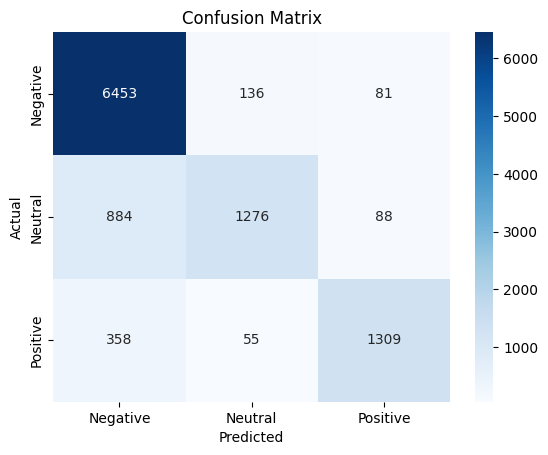

In [30]:
# Confusion Matrix
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [31]:
results = []

In [32]:
def train_and_evaluate(model, name):
    model.fit(X, y)
    y_pred = model.predict(X)

    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='macro')

    results.append({'Model': name, 'Accuracy': acc, 'F1-Macro': f1})

    print(f"\n=== {name} ===")
    print("Accuracy :", acc)
    print("F1-Macro :", f1)
    print("\nClassification Report:")
    print(classification_report(y, y_pred, target_names=le.classes_))

    #disp = ConfusionMatrixDisplay.from_predictions(y, y_pred, display_labels=le.classes_)
    #disp.ax_.set_title(f"Confusion Matrix: {name}")
    #plt.show()

In [33]:
models = [
    (LogisticRegression(), "Logistic Regression"),
    (LinearSVC(), "Support Vector Machine"),
    (MultinomialNB(), "Naive Bayes"),
  ]

for model, name in models:
    train_and_evaluate(model, name)


=== Logistic Regression ===
Accuracy : 0.9426691729323309
F1-Macro : 0.9269559159849127

Classification Report:
              precision    recall  f1-score   support

    negative       0.95      0.98      0.96      6670
     neutral       0.91      0.86      0.88      2248
    positive       0.94      0.92      0.93      1722

    accuracy                           0.94     10640
   macro avg       0.94      0.92      0.93     10640
weighted avg       0.94      0.94      0.94     10640


=== Support Vector Machine ===
Accuracy : 0.9758458646616541
F1-Macro : 0.9687729077318137

Classification Report:
              precision    recall  f1-score   support

    negative       0.98      0.99      0.99      6670
     neutral       0.96      0.94      0.95      2248
    positive       0.97      0.98      0.97      1722

    accuracy                           0.98     10640
   macro avg       0.97      0.97      0.97     10640
weighted avg       0.98      0.98      0.98     10640


=== Naiv

Read the test data and carry our data cleaning, encoding and vectorising operations on the test data

In [34]:
tweets_test = pd.read_csv('/content/drive/MyDrive/edureka/AI/Tweets-test/Tweets-test.csv', usecols=['airline_sentiment','text'])
#tweets_test = pd.read_csv('Tweets-test.csv', usecols=['airline_sentiment','text'])
tweets_test.head()

,airline_sentiment,text
0,negative,@AmericanAir why did you drop my call. Why don...
1,negative,@USAirways thanks for the seat that doesn't re...
2,negative,@AmericanAir wasn't just a delay. Your counter...
3,positive,@united social media team is on point on #Osca...
4,neutral,@AmericanAir These birds could fly to South Am...


In [35]:
tweets_test['clean_text'] = tweets.text.apply(clean)
tweets_test[['text', 'clean_text']].head()

,text,clean_text
0,@AmericanAir why did you drop my call. Why don...,"[plus, youve, added, commercials, to, the, exp..."
1,@USAirways thanks for the seat that doesn't re...,"[i, didnt, today, must, mean, i, need, to, tak..."
2,@AmericanAir wasn't just a delay. Your counter...,"[its, really, aggressive, to, blast, obnoxious..."
3,@united social media team is on point on #Osca...,"[and, its, a, really, big, bad, thing, about, it]"
4,@AmericanAir These birds could fly to South Am...,"[yes, nearly, every, time, i, fly, vx, this, e..."


In [36]:
# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
tweets_test['tweet_without_stopwords'] = tweets_test['clean_text'].apply(lambda x: [item for item in x if item not in stop])

In [37]:
# remove stopwords with Python's list comprehension and pandas.DataFrame.apply.
tweets_test['tweet_words_removed'] = tweets_test['tweet_without_stopwords'].apply(lambda x: [item for item in x if item not in remove_words])

In [38]:
tweets_test['tweet_final'] = tweets_test['tweet_words_removed'].apply(str1)

In [39]:
X_tweet_test = vectorizer.transform(tweets_test['tweet_final'])

In [40]:
y_tweet_test = tweets_test['airline_sentiment']

In [41]:
X_tweet_test.shape

(4000, 11550)

Predict the sentiments for test data and Compute Accuracy of your model

In [42]:
results_test = []

In [43]:
def evaluate(model, name):
    model.fit(X, y)
    y_pred_test = model.predict(X_tweet_test)

    acc_test = accuracy_score(y_tweet_test, y_pred_test)
    f1_test = f1_score(y_tweet_test, y_pred_test, average='macro')

    results_test.append({'Model': name, 'Accuracy': acc_test, 'F1-Macro': f1_test})

    print(f"\n=== {name} ===")
    print("Accuracy :", acc_test)
    print("F1-Macro :", f1_test)
    print("\nClassification Report:")
    print(classification_report(y_tweet_test, y_pred_test, target_names=le.classes_))

    #disp = ConfusionMatrixDisplay.from_predictions(y, y_pred, display_labels=le.classes_)
    #disp.ax_.set_title(f"Confusion Matrix: {name}")
    #plt.show()

In [44]:
models = [
    (LogisticRegression(), "Logistic Regression"),
    (LinearSVC(), "Support Vector Machine"),
    (MultinomialNB(), "Naive Bayes"),
  ]

for model, name in models:
  evaluate(model, name)


=== Logistic Regression ===
Accuracy : 0.45725
F1-Macro : 0.3209782797385395

Classification Report:
              precision    recall  f1-score   support

    negative       0.61      0.63      0.62      2508
     neutral       0.20      0.18      0.19       851
    positive       0.15      0.15      0.15       641

    accuracy                           0.46      4000
   macro avg       0.32      0.32      0.32      4000
weighted avg       0.45      0.46      0.45      4000


=== Support Vector Machine ===
Accuracy : 0.451
F1-Macro : 0.32061035389106035

Classification Report:
              precision    recall  f1-score   support

    negative       0.61      0.61      0.61      2508
     neutral       0.20      0.19      0.20       851
    positive       0.15      0.16      0.15       641

    accuracy                           0.45      4000
   macro avg       0.32      0.32      0.32      4000
weighted avg       0.45      0.45      0.45      4000


=== Naive Bayes ===
Accuracy : 

In [45]:
results

[{'Model': 'Logistic Regression',
  'Accuracy': 0.9426691729323309,
  'F1-Macro': 0.9269559159849127},
 {'Model': 'Support Vector Machine',
  'Accuracy': 0.9758458646616541,
  'F1-Macro': 0.9687729077318137},
 {'Model': 'Naive Bayes',
  'Accuracy': 0.8494360902255639,
  'F1-Macro': 0.801167837102667}]

In [46]:
results_test

[{'Model': 'Logistic Regression',
  'Accuracy': 0.45725,
  'F1-Macro': 0.3209782797385395},
 {'Model': 'Support Vector Machine',
  'Accuracy': 0.451,
  'F1-Macro': 0.32061035389106035},
 {'Model': 'Naive Bayes',
  'Accuracy': 0.49425,
  'F1-Macro': 0.32070570504025947}]

All models are overfitting . However best model is Naive Bayes. It is showing least amount of overfitting.

In [47]:
y_pred_test = model.predict(X_tweet_test)
acc_test = accuracy_score(y_tweet_test, y_pred_test)
print("Accuracy :", acc_test)

Accuracy : 0.49425


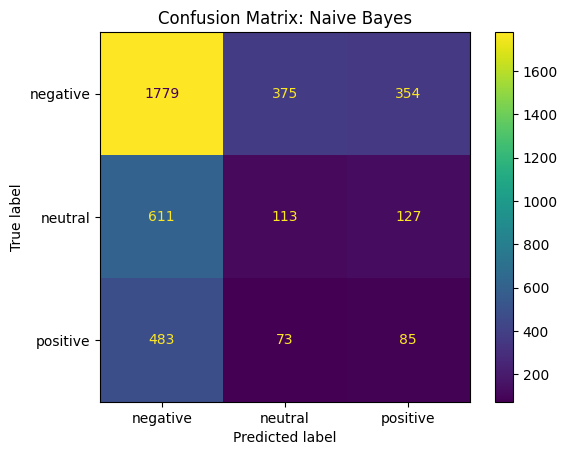

In [48]:
disp = ConfusionMatrixDisplay.from_predictions(y_tweet_test, y_pred_test, display_labels=le.classes_)
disp.ax_.set_title(f"Confusion Matrix: {name}")
plt.show()